In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(12,5)})
%load_ext autoreload
%autoreload 2 

In [2]:
import sys
import os
import itertools
import re
from functools import cmp_to_key
sys.path.append(os.path.abspath('../modules'))
from hard_rules import candidate_cookies, versions_key, compare_versions

In [84]:
data = pd.read_parquet("../Data/10K_HH.parquet")

In [85]:
data = data[data["maid"]==7]

In [86]:
data["time"].apply(lambda t: (t.year, t.month)).value_counts().sort_index()

(2021, 12)         56
(2022, 1)         365
(2022, 2)          22
(2022, 12)    1329060
(2023, 1)     1402187
(2023, 2)      669026
Name: time, dtype: int64

In [87]:
data = data[data["time"] >= pd.to_datetime("2022-12-01")]

In [88]:
pattern = re.compile(r'^\d+(\.\d+)*$')
data = data[data.osversion.str.match(pattern)]

In [89]:
pattern = re.compile(r'^\d+(\.\d+)*$')
data = data[data.browserversion.str.match(pattern)]

In [22]:
grouped = data.groupby(['hh_id', 'iiqid']).agg({'time': ['min', 'max']})

In [23]:
grouped["lifespan"] = grouped[("time", "max")] - grouped[("time", "min")]

In [24]:
grouped["lifespan"] = grouped["lifespan"].apply(lambda t: t.days)

In [25]:
data.head()

,timestamp,filename,iiqid,hh_id,maid,partner_id,ip,iscellip,cellispid,domain,...,osversion,browser,advertisedbrowser,browserversion,type,is_best_ip,time,is_hh,prev_osversion,prev_browserversion
5305360,1669852802551,HH_M,WorsfJNhdF,OVfCx6ZAeC,7,10253,1014397863,False,-1793086944,-1297673767,...,10,edge,Edge,107.0.1418.56,desktop,False,2022-12-01 00:00:02.551,True,0,0.0.0.0
274574,1669852802551,HH_M,WorsfJNhdF,OVfCx6ZAeC,7,10253,1014397863,False,-1793086944,-1297673767,...,10,edge,Edge,107.0.1418.56,desktop,False,2022-12-01 00:00:02.551,True,10,107.0.1418.56
5799545,1669852815024,NHB_M,xR6Olq5vyY,1096230683,7,14,1096235864,False,-785738892,1632511751,...,9,chrome mobile,Facebook on Android,9,smartphone,False,2022-12-01 00:00:15.024,True,0,0.0.0.0
1884467,1669852821516,HH_M,3bsIDAAL9s,uH94IApkve,7,14,1255127361,False,1891219528,-1545077811,...,10,chrome desktop,Chrome,108.0.0.0,desktop,False,2022-12-01 00:00:21.516,True,0,0.0.0.0
6016795,1669852821516,HH_M,3bsIDAAL9s,uH94IApkve,7,14,1255127361,False,1891219528,-1545077811,...,10,chrome desktop,Chrome,108.0.0.0,desktop,False,2022-12-01 00:00:21.516,True,10,108.0.0.0


In [26]:
grouped.lifespan.max()

84

<Axes: xlabel='lifespan', ylabel='Count'>

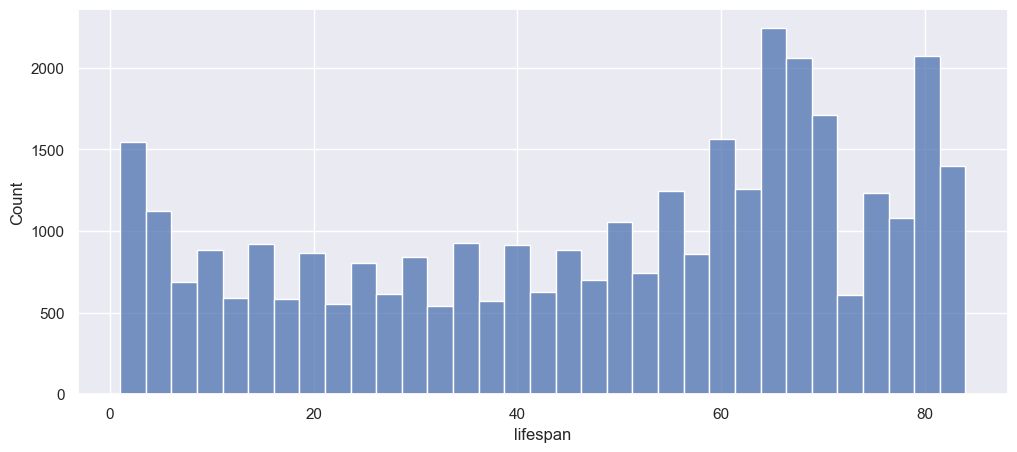

In [28]:
sns.histplot(data=grouped[grouped["lifespan"]>0], x="lifespan")
# sns.histplot(data=grouped, x="lifespan")

<BarContainer object of 2 artists>

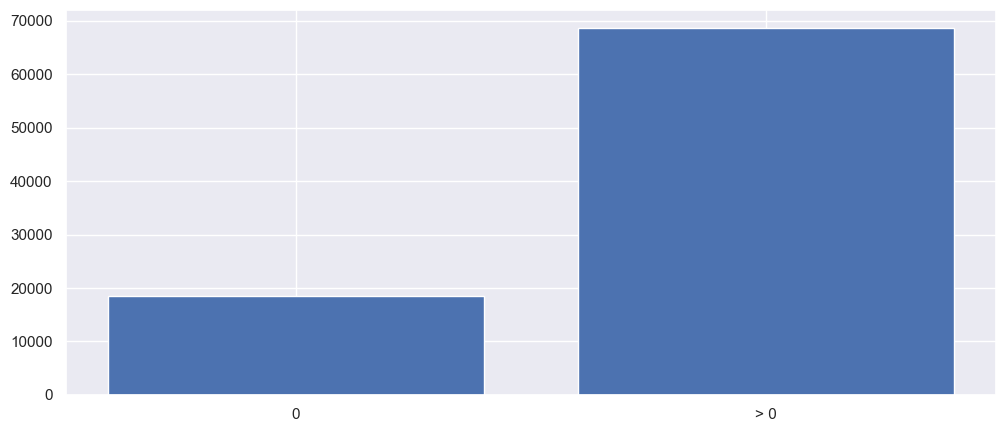

In [50]:
plt.bar(["0","> 0"], 
        [len(grouped[grouped["lifespan"]==0]), len(grouped[grouped["lifespan"]>0])])

In [51]:
grouped.head()

time                         lifespan
                                          min                     max         
hh_id      iiqid                                                              
008lj1AMI8 6MILYBoI9P 2022-12-06 20:30:42.973 2023-02-03 17:29:52.687       58
           UVg62Vt8Va 2022-12-04 06:04:54.956 2023-02-03 22:48:53.120       61
           WATS0P8zVm 2023-01-04 09:04:24.973 2023-02-08 09:39:50.615       35
           X93J3N7vAC 2022-12-02 03:20:07.416 2023-01-02 06:31:36.724       31
           eIVlRbV49r 2023-01-06 00:40:28.200 2023-02-09 03:11:06.924       34

In [89]:
one_row = grouped[grouped["lifespan"] > 60].sample(1)
one_row

time                         lifespan
                                         min                     max         
hh_id     iiqid                                                              
418078058 Bcjz15r0Ms 2022-12-08 05:04:58.662 2023-02-20 04:49:41.883       73

In [90]:
one_cookie = one_row.index.get_level_values(1).values[0]

In [91]:
one_cookie

'Bcjz15r0Ms'

In [92]:
one_cookie_data = data[data["iiqid"]==one_cookie]

In [93]:
one_cookie_data.browser.value_counts()

chrome mobile    37
Name: browser, dtype: int64

In [94]:
most_common_brw = one_cookie_data.browser.mode().iloc[0]

In [95]:
one_cookie_data = one_cookie_data[one_cookie_data["browser"]==most_common_brw]

<Axes: xlabel='time', ylabel='browserversion'>

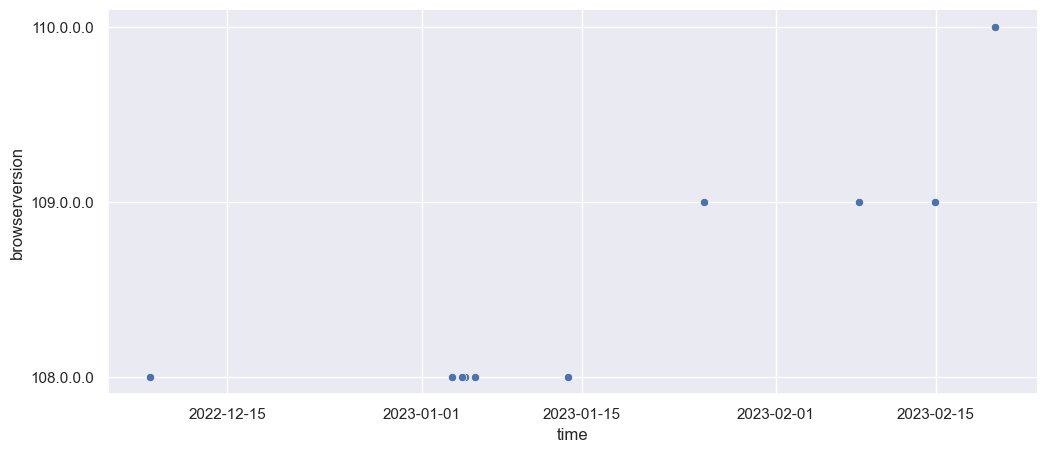

In [96]:
sns.scatterplot(data=one_cookie_data, x="time", y="browserversion")

## Lets try to find how many error are they

For a given cookie:
Go over all of its apearesnces and see if the browserversion stays consistent.
Lets strat by a simple "yes/no" test.

In [99]:
one_cookie_data = one_cookie_data.sort_values(by="time")

In [108]:
one_cookie_data["prev_browserversion"] = one_cookie_data["browserversion"].shift(1).fillna("0.0.0.0")

In [115]:
all(np.vectorize(compare_versions)(one_cookie_data['prev_browserversion'], one_cookie_data['browserversion']) <= 0)

True

In [116]:
def has_no_errors(cookie, df=data):
    one_cookie_data = df[df["iiqid"]==cookie].sort_values(by="time")
    one_cookie_data["prev_browserversion"] = one_cookie_data["browserversion"].shift(1).fillna("0.0.0.0")
    one_cookie_data["prev_osversion"] = one_cookie_data["osversion"].shift(1).fillna("0")
    browser_consistency = all(np.vectorize(compare_versions)(one_cookie_data['prev_browserversion'], one_cookie_data['browserversion']) <= 0)
    os_consistency = all(np.vectorize(compare_versions)(one_cookie_data['osversion'], one_cookie_data['osversion']) <= 0)
    return browser_consistency and os_consistency

In [119]:
has_no_errors(one_cookie)

True

In [8]:
data.sort_values(by="time", inplace=True)
# grouped_cookies = data.groupby(["hh_id", "iiqid"])

In [9]:
data['prev_osversion'] = data.groupby(['hh_id', 'iiqid'])['osversion'].shift(1).fillna("0")
data['prev_browserversion'] = data.groupby(['hh_id', 'iiqid'])['browserversion'].shift(1).fillna("0.0.0.0")

In [10]:
full_valid_rows = data[(np.vectorize(compare_versions)(data['osversion'], 
                                                         data['prev_osversion']) >= 0)
                       & (np.vectorize(compare_versions)(data['browserversion'], 
                                                               data['prev_browserversion']) >= 0)]

In [12]:
ok_rows_counts = full_valid_rows.groupby(['hh_id', 'iiqid']).size()

In [13]:
total_rows_counts = data.groupby(['hh_id', 'iiqid']).size()

In [14]:
all_ok = ok_rows_counts.eq(total_rows_counts)

In [16]:
all_ok.head(10)

hh_id       iiqid     
008lj1AMI8  6MILYBoI9P    True
            UVg62Vt8Va    True
            WATS0P8zVm    True
            mXwL7QCw5O    True
            vjNRSKwlH4    True
00C30KAqMf  MkDZdCUiPK    True
017VVGbSKq  7Gqmdx5cAS    True
            9LwaJRXNWe    True
            Gc8OsRzRW1    True
            xTgngXvS70    True
dtype: bool

In [17]:
result = pd.concat([total_rows_counts, all_ok], axis=1)
result.columns = ['instances','ok'] 

In [18]:
result

instances     ok
hh_id      iiqid                       
008lj1AMI8 6MILYBoI9P         66   True
           UVg62Vt8Va         41   True
           WATS0P8zVm        156   True
           mXwL7QCw5O         51   True
           vjNRSKwlH4         28   True
...                          ...    ...
zygR659Gbx zU35cTjEsV        595  False
zzyXvF318v 0UXCVZvWch         40  False
           26UHp1Gc7Y         46   True
           2oWL7w8Na8          2   True
           uo36TXLVcg        126  False

[48506 rows x 2 columns]

<Axes: xlabel='ok', ylabel='count'>

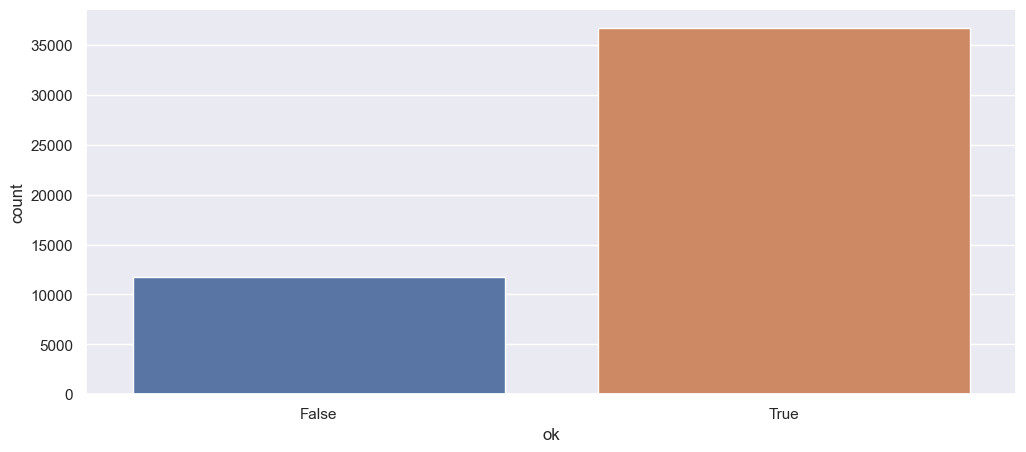

In [19]:
sns.countplot(data=result, x='ok')

In [35]:
cookie_hhd_data = pd.concat([grouped, result], axis=1)
cookie_hhd_data.columns = ["time_min", "time_max", "lifespan", "instances", "ok"]

In [81]:
lifespan_order = [str(i) for i in range(84, -1, -1)]

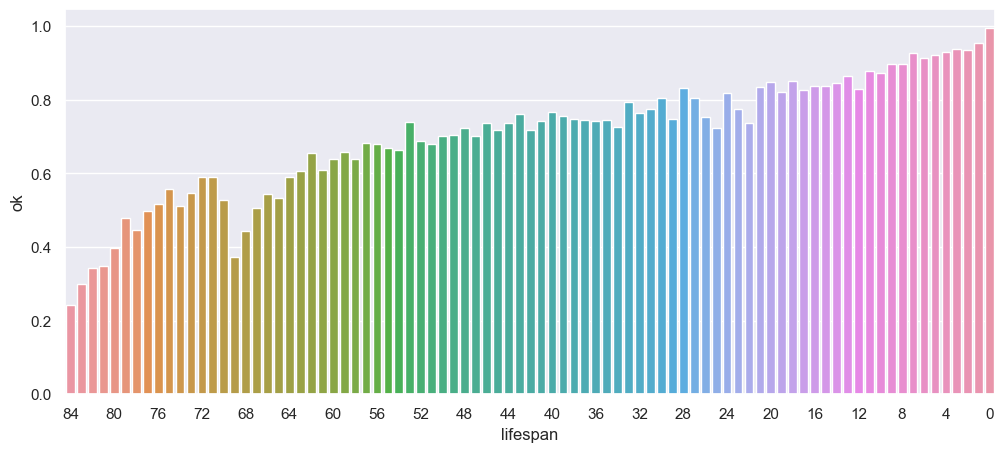

In [88]:
sns.barplot(data=cookie_hhd_data, x="lifespan", y="ok", errorbar=None, order=list(reversed(range(0, 85))))
plt.xticks(range(0, 85, 4));

In [356]:
found = False
while not found:
    one_cookie_sample = cookie_hhd_data[cookie_hhd_data["ok"]==False].sample()
    one_cookie_id = one_cookie_sample.index.get_level_values(1).values[0]
    one_cookie_data = data[data["iiqid"]==one_cookie_id]
    browsers_of_cookie = one_cookie_data.browser.value_counts().sort_values(ascending=False)
    if browsers_of_cookie.sum() > 25:
        if len(browsers_of_cookie) > 1:
            if browsers_of_cookie.iloc[1]  > browsers_of_cookie.sum()/4:
                found = True

In [330]:
one_cookie_sample = cookie_hhd_data[cookie_hhd_data["ok"]==False].sample()

In [331]:
one_cookie_id = one_cookie_sample.index.get_level_values(1).values[0]

In [332]:
one_cookie_data = data[data["iiqid"]==one_cookie_id]

In [337]:
browsers_of_cookie = one_cookie_data.browser.value_counts().sort_values(ascending=False)

In [342]:
browsers_of_cookie.sum()/4

26.25

In [357]:
one_cookie_data.browser.value_counts()

chrome desktop    50
safari            29
Name: browser, dtype: int64

In [347]:
ordered_versions = sorted(one_cookie_data.browserversion.unique(), key=cmp_to_key(compare_versions))

<Axes: xlabel='time', ylabel='browserversion'>

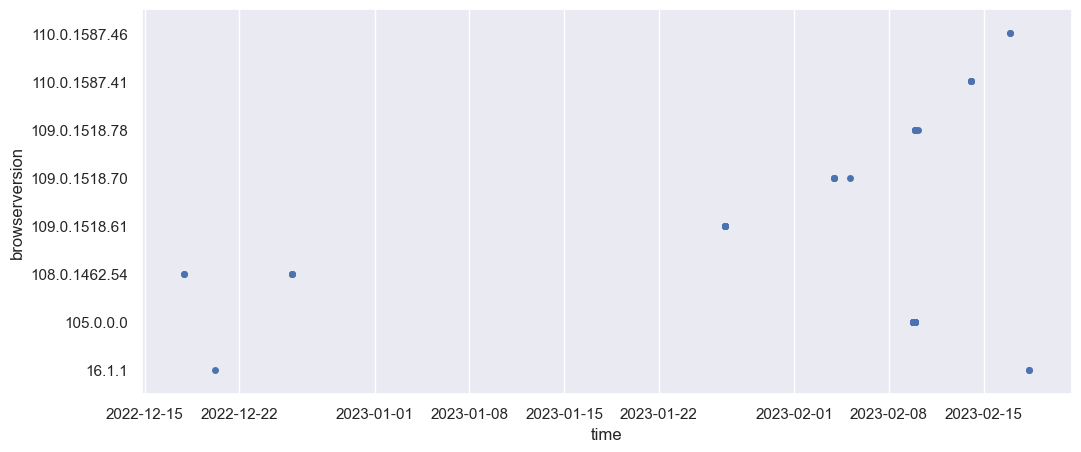

In [348]:
sns.stripplot(data=one_cookie_data, x="time", y="browserversion", 
              order=ordered_versions[::-1], jitter=False)

In [349]:
# one_cookie_data[one_cookie_data["browserversion"].apply(lambda v: v[0]=="2")]

In [354]:
one_cookie_id

'xmyR15e8dP'

<Axes: title={'center': "Cookie's iiqid: V5F1rG6Krd"}>

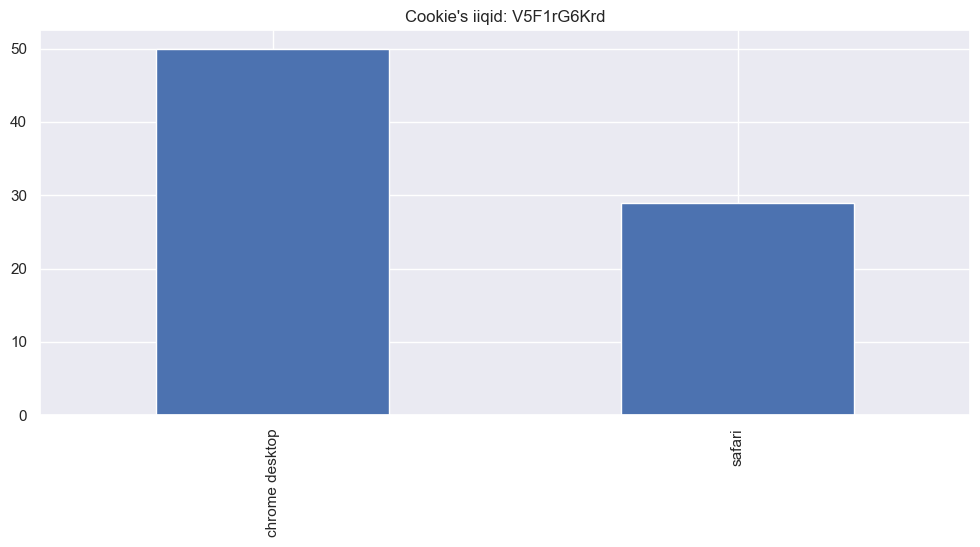

In [358]:
one_cookie_data.browser.value_counts().plot.bar(title=f"Cookie's iiqid: {one_cookie_id}")

## Mixed Constant For One Cookie

In [9]:
# data.groupby(["hh_id", "iiqid", 

In [10]:
unique_values_per_cookie = data.groupby(["hh_id", "iiqid"])[["timestamp", "brand", "model", "os", "browser"]].nunique()

In [11]:
unique_values_per_cookie["sum"] = unique_values_per_cookie.iloc[:,1:].sum(axis=1)

In [12]:
equal_4 = unique_values_per_cookie[unique_values_per_cookie["sum"]==4]
more_than_4 = unique_values_per_cookie[unique_values_per_cookie["sum"]>4]

Text(0.5, 1.0, 'Number of user agents assosiated with each cookie')

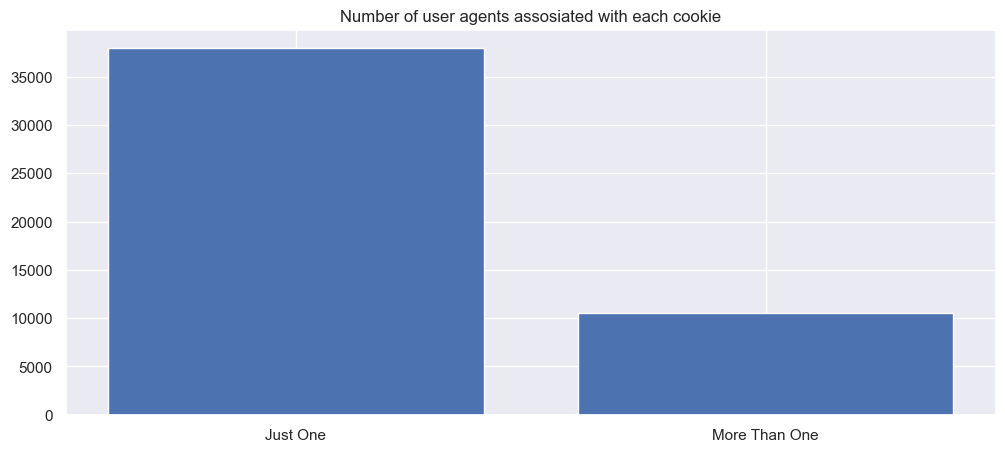

In [13]:
plt.bar(["Just One", "More Than One"], [len(equal_4), len(more_than_4)])
plt.title("Number of user agents assosiated with each cookie")

In [53]:
column_pick = "browser"
browser_counts = data.groupby(["hh_id", "iiqid"])[column_pick].value_counts()

In [54]:
unstacked_browser_counts = browser_counts.unstack(level=2).fillna(0).astype(int)

In [55]:
unstacked_browser_counts["mode"] = unstacked_browser_counts.idxmax(axis=1)

In [56]:
unstacked_browser_counts["total"] = unstacked_browser_counts.select_dtypes('number').sum(axis=1)

In [57]:
def get_value(row):
    return row[row['mode']]

unstacked_browser_counts["mode_count"] = unstacked_browser_counts.apply(get_value, axis=1)

In [58]:
unstacked_browser_counts["mode_fraction"] = unstacked_browser_counts["mode_count"] / unstacked_browser_counts["total"]

Text(0.5, 1.0, 'Distribution of UA homogeneity per cookie')

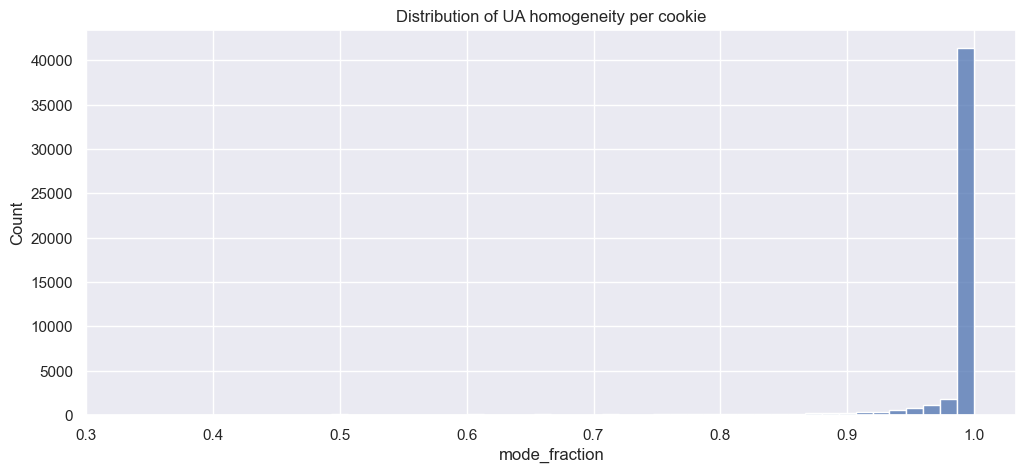

In [59]:
sns.histplot(data=unstacked_browser_counts, x="mode_fraction", bins=50)
plt.title("Distribution of UA homogeneity per cookie")

Text(0.5, 1.0, 'Distribution of UA homogeneity per cookie')

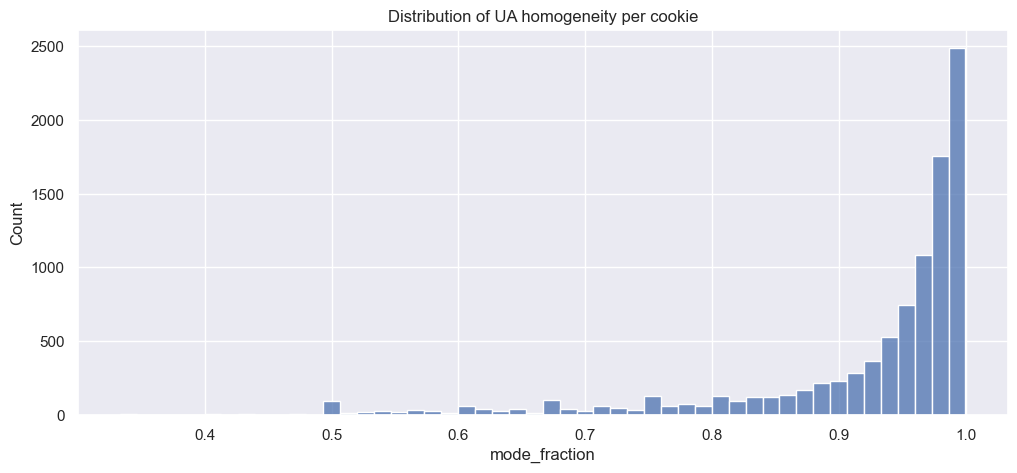

In [73]:
sns.histplot(data=unstacked_browser_counts[unstacked_browser_counts["mode_fraction"] < 1], x="mode_fraction", bins=50)
plt.title("Distribution of UA homogeneity per cookie")

## ow many errors are they, if we exclude the mixed UA

In [97]:
non_mixed_data = data[data["iiqid"].isin(equal_4.index.get_level_values(1).to_list())]

In [99]:
non_mixed_data = non_mixed_data.sort_values(by="time")

In [100]:
non_mixed_data['prev_osversion'] = non_mixed_data.groupby(['hh_id', 'iiqid'])['osversion'].shift(1).fillna("0")
non_mixed_data['prev_browserversion'] = non_mixed_data.groupby(['hh_id', 'iiqid'])['browserversion'].shift(1).fillna("0.0.0.0")

In [101]:
full_valid_rows = non_mixed_data[(np.vectorize(compare_versions)(non_mixed_data['osversion'], 
                                                         non_mixed_data['prev_osversion']) >= 0)
                       & (np.vectorize(compare_versions)(non_mixed_data['browserversion'], 
                                                               non_mixed_data['prev_browserversion']) >= 0)]

In [102]:
ok_rows_counts = full_valid_rows.groupby(['hh_id', 'iiqid']).size()

In [103]:
total_rows_counts = non_mixed_data.groupby(['hh_id', 'iiqid']).size()

In [104]:
all_ok = ok_rows_counts.eq(total_rows_counts)

In [105]:
result = pd.concat([total_rows_counts, all_ok], axis=1)
result.columns = ['instances','ok'] 

<Axes: xlabel='ok', ylabel='count'>

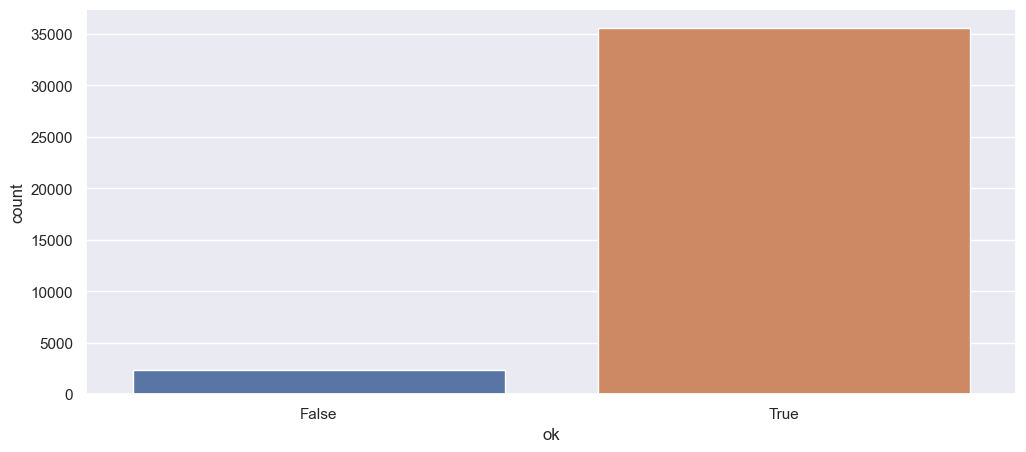

In [107]:
sns.countplot(data=result, x='ok')

In [110]:
grouped = non_mixed_data.groupby(['hh_id', 'iiqid']).agg({'time': ['min', 'max']})

In [111]:
grouped["lifespan"] = grouped[("time", "max")] - grouped[("time", "min")]

In [112]:
grouped["lifespan"] = grouped["lifespan"].apply(lambda t: t.days)

In [113]:
cookie_hhd_data = pd.concat([grouped, result], axis=1)
cookie_hhd_data.columns = ["time_min", "time_max", "lifespan", "instances", "ok"]

In [114]:
lifespan_order = [str(i) for i in range(84, -1, -1)]

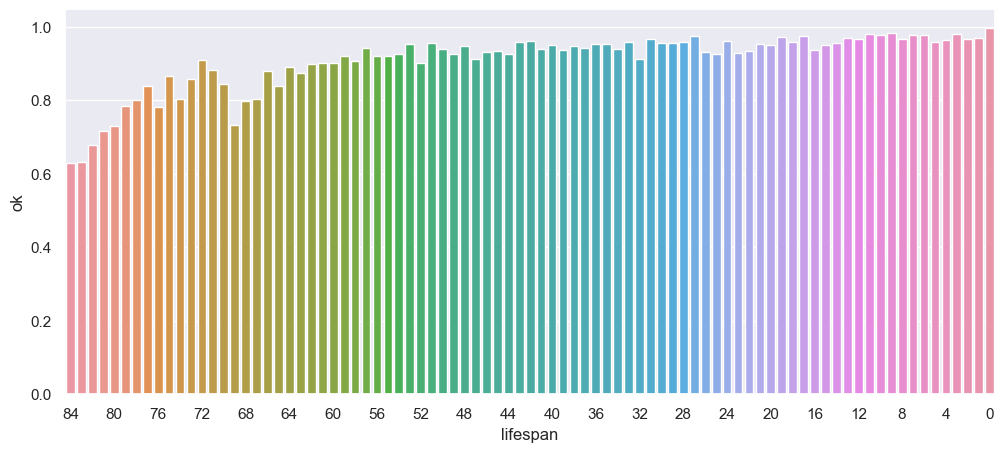

In [115]:
sns.barplot(data=cookie_hhd_data, x="lifespan", y="ok", errorbar=None, order=list(reversed(range(0, 85))))
plt.xticks(range(0, 85, 4));

In [129]:
# cookie_hhd_data["instances"].plot.hist()
sum(cookie_hhd_data["instances"] > 500) / len(cookie_hhd_data)

0.005588064737202804

<Axes: xlabel='instances', ylabel='ok'>

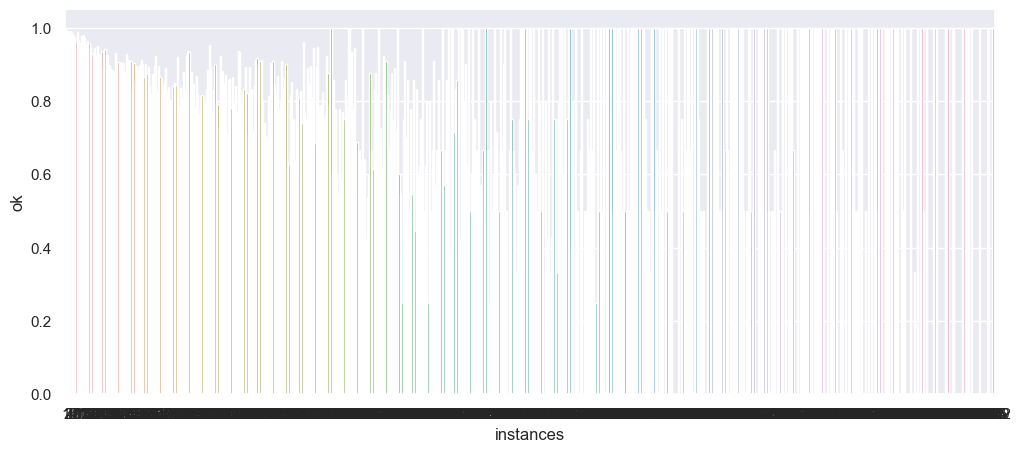

In [137]:
sns.barplot(data=cookie_hhd_data, x="instances", y="ok", errorbar=None) #, order=list(reversed(range(0, 85))))
# plt.xticks(range(0, 500, 50))
# plt.xlim(0, 500);

In [136]:
cookie_hhd_data.head()

time_min                time_max  \
hh_id      iiqid                                                        
008lj1AMI8 6MILYBoI9P 2022-12-06 20:30:42.973 2023-02-03 17:29:52.687   
           UVg62Vt8Va 2022-12-04 06:04:54.956 2023-02-03 22:48:53.120   
           WATS0P8zVm 2023-01-04 09:04:24.973 2023-02-08 09:39:50.615   
           mXwL7QCw5O 2022-12-02 17:01:54.895 2023-02-08 13:58:34.536   
           vjNRSKwlH4 2022-12-01 20:43:03.895 2023-01-05 06:20:52.917   

                       lifespan  instances    ok  
hh_id      iiqid                                  
008lj1AMI8 6MILYBoI9P        58         66  True  
           UVg62Vt8Va        61         41  True  
           WATS0P8zVm        35        156  True  
           mXwL7QCw5O        67         51  True  
           vjNRSKwlH4        34         28  True

In [244]:
found = False
while not found:
    one_cookie_sample = cookie_hhd_data[cookie_hhd_data["ok"]==False].sample()
    one_cookie_id = one_cookie_sample.index.get_level_values(1).values[0]
    one_cookie_data = data[data["iiqid"]==one_cookie_id]
    browsers_of_cookie = one_cookie_data.browser.value_counts().sort_values(ascending=False)
    if browsers_of_cookie.sum() > 25:
        if len(browsers_of_cookie) == 1:
            found = True

In [245]:
ordered_versions = sorted(one_cookie_data.browserversion.unique(), key=cmp_to_key(compare_versions))

Text(0.5, 1.0, "Cookie's iiqid: uwMFDFZwoX")

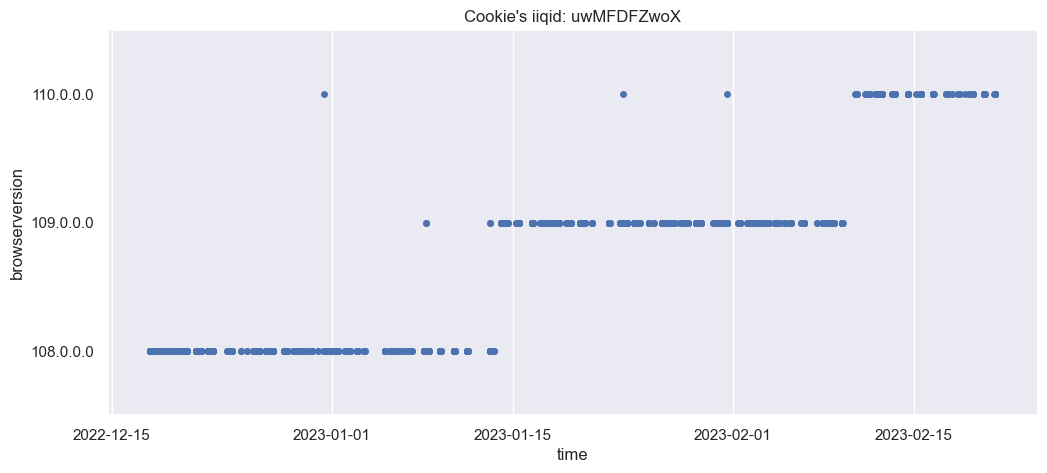

In [246]:
sns.stripplot(data=one_cookie_data, x="time", y="browserversion", 
              order=ordered_versions[::-1], jitter=False)
plt.title(f"Cookie's iiqid: {one_cookie_id}")

In [247]:
one_cookie_data.to_csv("another_example_for_version_noise.csv")